In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import config

In [2]:
#Load google.cloud.bigquery
%load_ext google.cloud.bigquery

In [3]:
#Select path to credentials
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]=config.GOOGLE_APPLICATION_CREDENTIALS

In [4]:
%%bigquery --use_rest_api ZRI_MF
SELECT *
FROM `high-empire-220313.ZRI.Multi_Family`

In [5]:
year_columns = [x for x in ZRI_MF.columns if ('20' in x)]

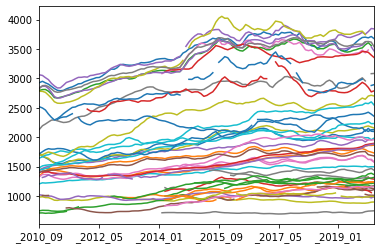

In [6]:
#Plot 50 largest zip code's ZRI over time
fig, ax = plt.subplots()
for i in range(1,50):
    ZRI_MF[ZRI_MF.SizeRank == i].loc[:,year_columns].transpose().plot(kind = 'line', ax = ax)
ax.get_legend().remove()

Next steps:
Use various time series analyses techniques to forecast purely based off of previous ZRI. 
